In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read data and visualize

In [3]:
def read_locations(file_name):
    raw_csv = pd.read_csv(file_name, index_col=None, header=None)
    x = raw_csv[0].str.split(' ').str[0].astype(float)
    y = raw_csv[0].str.split(' ').str[1].astype(float)
    data = {'x':x, 'y':y}
    
    return data

train_data = read_locations('data/demo_train.csv')
test_data = read_locations('data/demo_test.csv')

Text(0.5, 1.0, 'Traning Set Trajectory')

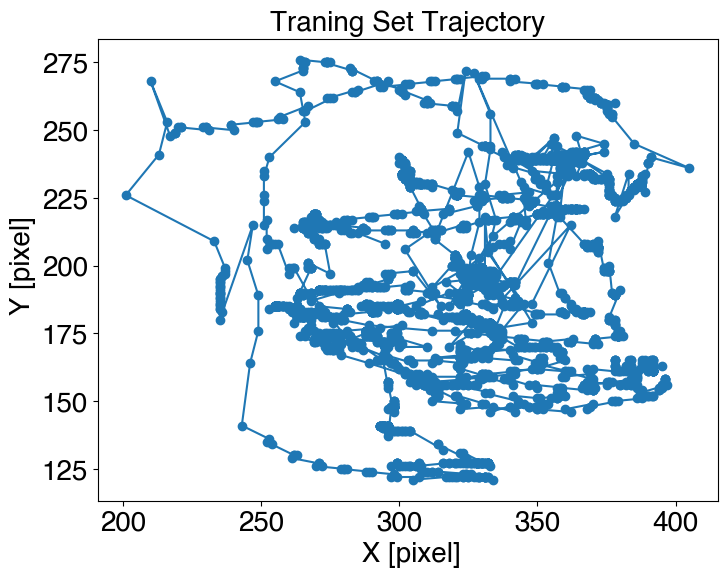

In [4]:
plt.rcParams.update({'font.size': 20, 'font.family': 'Helvetica'})
fig, ax = plt.subplots(figsize=(8, 6))

data_plot = train_data
ax2 = plt.subplot(111)
plt.plot(data_plot['x'], data_plot['y'])
plt.scatter(data_plot['x'], data_plot['y'] )


ax2.set_xlabel(' X [pixel]', fontsize=20)
ax2.set_ylabel(' Y [pixel]', fontsize=20)
ax2.set_title('Traning Set Trajectory', fontsize=20)

Text(0.5, 1.0, 'Testing Set Trajectory')

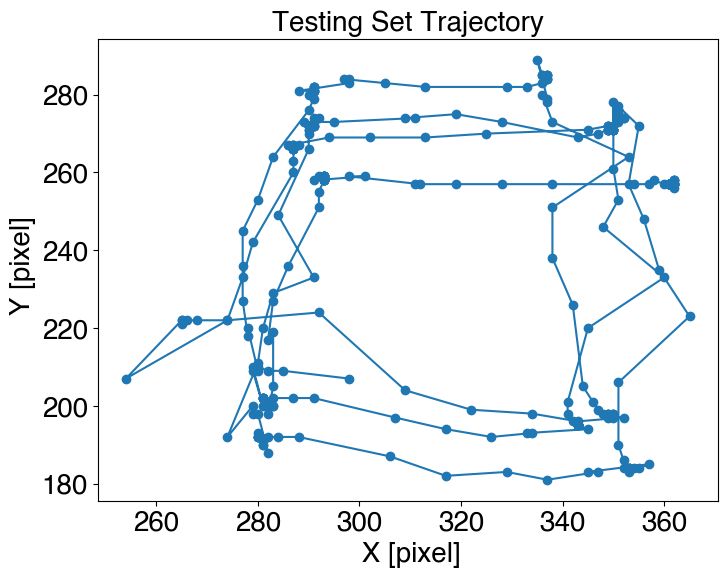

In [5]:
plt.rcParams.update({'font.size': 20, 'font.family': 'Helvetica'})
fig, ax = plt.subplots(figsize=(8, 6))

data_plot = test_data
ax2 = plt.subplot(111)
plt.plot(data_plot['x'], data_plot['y'])
plt.scatter(data_plot['x'], data_plot['y'] )

ax2.set_xlabel(' X [pixel]', fontsize=20)
ax2.set_ylabel(' Y [pixel]', fontsize=20)
ax2.set_title('Testing Set Trajectory', fontsize=20)

# double exponential filter prediction

In [6]:
def double_exponential_smoothing_seperate(series, alpha, beta, n_preds):
    """
    Given a series, alpha, beta and n_preds (number of
    forecast/prediction steps), perform the prediction.
    """
    n_record = series.shape[0]

    level = series[0]
    trend = series[1] - series[0]
    for t in range(1, n_record):
        #         print(level, trend)
        if t >= n_record:
            # forecasting new points
            value = results[t - 1]
        else:
            value = series[t]

        previous_level = level
        level = alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - previous_level) + (1 - beta) * trend
        results = level + trend * n_preds

    return results

In [7]:
## find the best params for double-exp filter with MAE+ MAAE metric

his_data = test_data
data_x = np.array(his_data['x'])
data_y = np.array(his_data['y'])
length_data = len(data_x)
a_error_min, error_min = 100000, 100000
best_alpha, best_beta = 0, 0
for alpha in np.arange(0.1, 1, 0.1):
    for beta in np.arange(0.1, 1, 0.01):


        x_predicted = np.zeros((length_data, 2))
        y_predicted = np.zeros((length_data, 2))

        for i in range(10, length_data-1):
            input_x = data_x[i-10:i]
            input_y = data_y[i-10:i]

            x_predicted[i+1, 1] = double_exponential_smoothing_seperate(input_x, alpha, beta, 2) # predict 2 samples ahead
            y_predicted[i+1, 1] = double_exponential_smoothing_seperate(input_y, alpha, beta, 2) # predict 2 samples ahead
        
        a_x = np.diff(np.diff(test_data['x'][11:]))
        a_y = np.diff(np.diff(test_data['y'][11:]))
        a_pred_x = np.diff(np.diff(x_predicted[11:, 1]))
        a_pred_y = np.diff(np.diff(y_predicted[11:, 1]))
        
        error_a = abs(a_x - a_pred_x).mean() + abs(a_y - a_pred_y).mean()
        error = abs(x_predicted[11:,1] - test_data['x'][11:]).mean() + abs(y_predicted[11:,1] - test_data['y'][11:]).mean()

        if error_a + error < a_error_min + error_min:
            a_error_min = error_a
            error_min = error
            best_alpha, best_beta = alpha, beta
        

print("best alpha, best beta: ", best_alpha, best_beta)


best alpha, best beta:  0.7000000000000001 0.3699999999999999


In [8]:
# DEF prediction with the best parameter
his_data = test_data
data_x = np.array(his_data['x'])
data_y = np.array(his_data['y'])

length_data = len(data_x)

x_predicted = np.zeros((length_data, 2))
y_predicted = np.zeros((length_data, 2))

# best_alpha, best_beta =0.7, 0.37

for i in range(10, length_data-1):
    input_x = data_x[i-10:i]
    input_y = data_y[i-10:i]

    x_predicted[i+1, 1] = double_exponential_smoothing_seperate(input_x, best_alpha, best_beta, 2) # predict 2 samples ahead
    y_predicted[i+1, 1] = double_exponential_smoothing_seperate(input_y, best_alpha, best_beta, 2) # predict 2 samples ahead
    

    
a_x = np.diff(np.diff(his_data['x'][11:]))
a_y = np.diff(np.diff(his_data['y'][11:]))
a_pred_x = np.diff(np.diff(x_predicted[11:, 1]))
a_pred_y = np.diff(np.diff(y_predicted[11:, 1]))

error_a = abs(a_x - a_pred_x).mean() + abs(a_y - a_pred_y).mean()

error_def = abs(x_predicted[11:,1] - his_data['x'][11:]).mean() + abs(y_predicted[11:,1] - his_data['y'][11:]).mean()

print("The double exponential prediction error is: ", error_def)

The double exponential prediction error is:  10.160310970532974


# visualization Best DEF filter prediction results

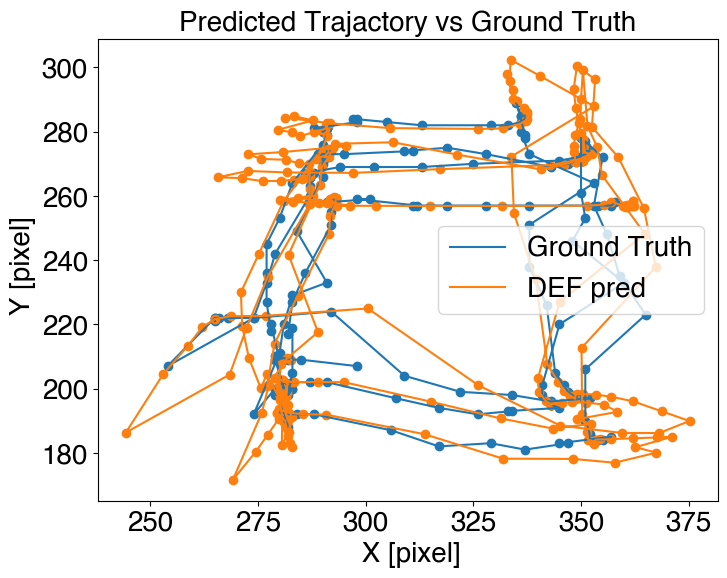

In [9]:
plt.rcParams.update({'font.size': 20, 'font.family': 'Helvetica'})
fig, ax = plt.subplots(figsize=(8, 6))

data_plot = test_data
ax2 = plt.subplot(111)
plt.plot(data_plot['x'][11:], data_plot['y'][11:], label = 'Ground Truth')
plt.scatter(data_plot['x'][11:], data_plot['y'][11:] )

plt.plot(x_predicted[11:,1], y_predicted[11:,1] ,label = 'DEF pred')
plt.scatter(x_predicted[11:,1], y_predicted[11:,1] )

ax2.set_xlabel(' X [pixel]', fontsize=20)
ax2.set_ylabel(' Y [pixel]', fontsize=20)
ax2.set_title('Predicted Trajactory vs Ground Truth', fontsize=20)
plt.legend()

/var/folders/4j/lh4sv7wd1dg5nwjlyq275z0c0000gn/T/ipykernel_5394/3961609946.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(121)


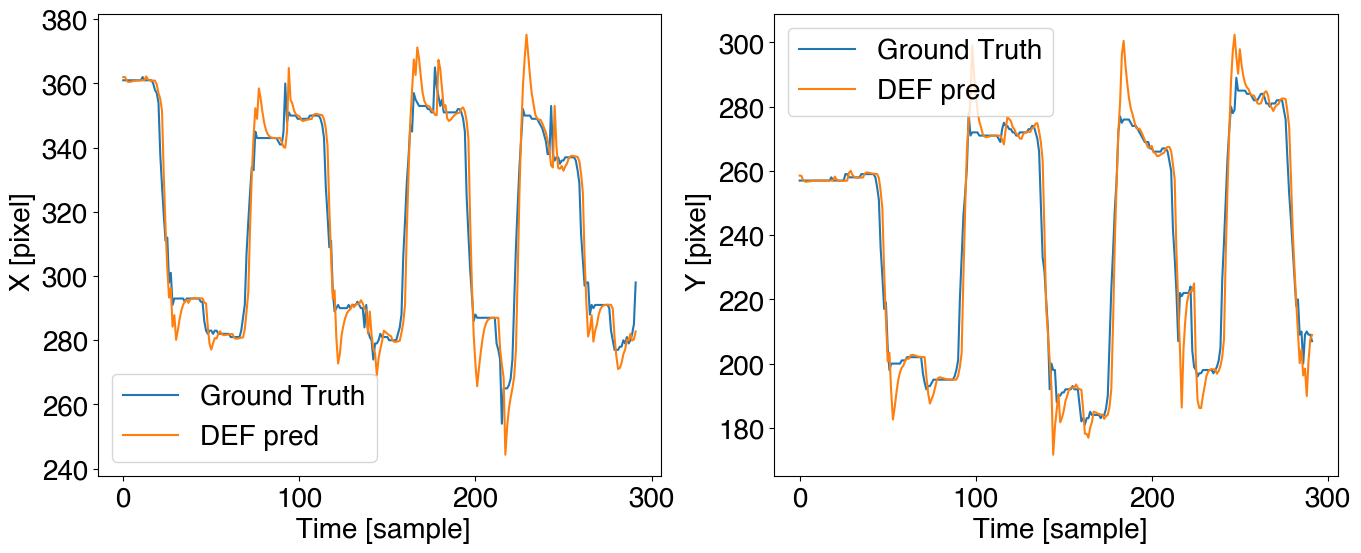

In [10]:
plt.rcParams.update({'font.size': 20, 'font.family': 'Helvetica'})
fig, ax = plt.subplots(figsize=(16, 6))

data_plot = test_data
ax2 = plt.subplot(121)
plt.plot(np.arange(len(data_plot['x'][11:])), data_plot['x'][11:], label = 'Ground Truth')
# plt.scatter(np.arange(len(data_plot['x'][21:])), data_plot['x'][21:])

plt.plot(np.arange(len(data_plot['x'][11:])), x_predicted[11:,1] ,label = 'DEF pred')
# plt.scatter(np.arange(len(data_plot['x'][21:])), x_predicted[21:,1])

ax2.set_ylabel(' X [pixel]', fontsize=20)
ax2.set_xlabel(' Time [sample]', fontsize=20)
plt.legend()

ax2 = plt.subplot(122)
plt.plot(np.arange(len(data_plot['y'][11:])), data_plot['y'][11:], label = 'Ground Truth')
# plt.scatter(data_plot['x'], data_plot['y'] )

plt.plot(np.arange(len(data_plot['y'][11:])), y_predicted[11:,1] ,label = 'DEF pred')
# plt.scatter(x_predicted[20:,1], y_predicted[20:,1] )

ax2.set_ylabel(' Y [pixel]', fontsize=20)
ax2.set_xlabel(' Time [sample]', fontsize=20)
plt.legend()

# read turbo predictor prediction results

In [11]:
turbo_pred = pd.read_csv('data/data_Turbo_predicted.csv')
turbo_pred

,When,X,Y,Typestate,predX,predY
0,1.112720e+15,362,256,DOWN,362.000,256.000
1,1.112720e+15,362,257,MOVE,362.000,257.000
2,1.112720e+15,362,257,MOVE,362.000,257.000
3,1.112720e+15,362,257,MOVE,362.000,256.969
4,1.112720e+15,362,257,MOVE,362.000,256.980
...,...,...,...,...,...,...
298,1.112760e+15,279,209,MOVE,275.425,202.093
299,1.112760e+15,280,210,MOVE,277.501,220.065
300,1.112760e+15,282,209,MOVE,288.479,212.176
301,1.112760e+15,285,209,MOVE,295.017,208.990


In [12]:
error_tur = abs(turbo_pred['predX'][11:] - turbo_pred['X'][11:]).mean() + abs(turbo_pred['predY'][11:] - turbo_pred['Y'][11:]).mean()
print("The TurboTouch prediction error is: ", error_tur)

The TurboTouch prediction error is:  17.706732876712326


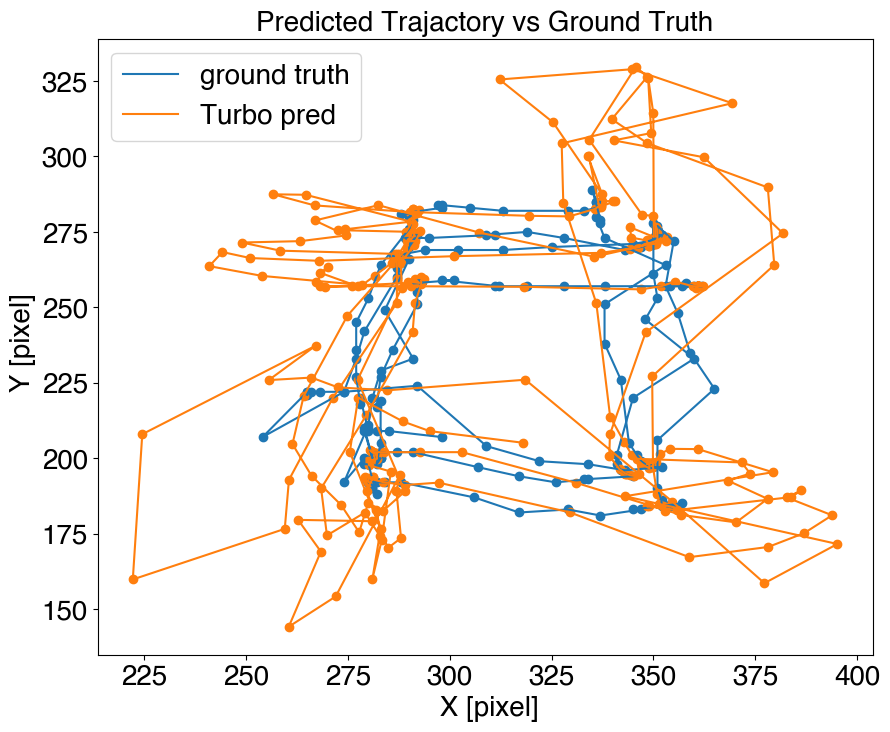

In [13]:
plt.rcParams.update({'font.size': 20, 'font.family': 'Helvetica'})
fig, ax = plt.subplots(figsize=(10, 8))

data_plot = test_data
ax2 = plt.subplot(111)

plt.plot(turbo_pred['X'][11:], turbo_pred['Y'][11:], label = 'ground truth')
plt.scatter(turbo_pred['X'][11:], turbo_pred['Y'][11:])

plt.plot(turbo_pred['predX'][11:], turbo_pred['predY'][11:], label = 'Turbo pred')
plt.scatter(turbo_pred['predX'][11:], turbo_pred['predY'][11:])

ax2.set_xlabel(' X [pixel]', fontsize=20)
ax2.set_ylabel(' Y [pixel]', fontsize=20)
ax2.set_title('Predicted Trajactory vs Ground Truth', fontsize=20)

plt.legend()

/var/folders/4j/lh4sv7wd1dg5nwjlyq275z0c0000gn/T/ipykernel_5394/3684588753.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(121)


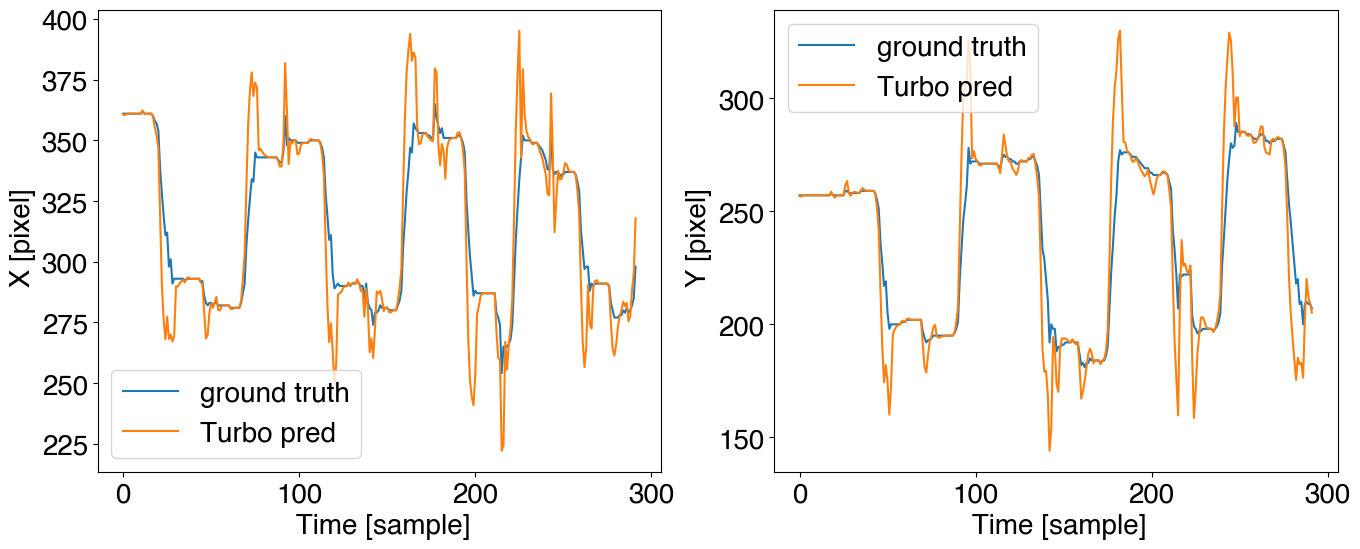

In [14]:
plt.rcParams.update({'font.size': 20, 'font.family': 'Helvetica'})
fig, ax = plt.subplots(figsize=(16, 6))

ax2 = plt.subplot(121)
plt.plot(np.arange(len(turbo_pred['X'][11:])), turbo_pred['X'][11:], label = 'ground truth')
plt.plot(np.arange(len(turbo_pred['predX'][11:])), turbo_pred['predX'][11:] ,label = 'Turbo pred')


ax2.set_ylabel(' X [pixel]', fontsize=20)
ax2.set_xlabel(' Time [sample]', fontsize=20)
plt.legend()

ax2 = plt.subplot(122)
plt.plot(np.arange(len(turbo_pred['Y'][11:])), turbo_pred['Y'][11:], label = 'ground truth')
plt.plot(np.arange(len(turbo_pred['predY'][11:])), turbo_pred['predY'][11:] ,label = 'Turbo pred')

ax2.set_ylabel(' Y [pixel]', fontsize=20)
ax2.set_xlabel(' Time [sample]', fontsize=20)
plt.legend()

# N-euro Predictor

In [15]:
import os
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet, LSTM, DeepAR
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, MAE, RMSE

from scipy.io import savemat



data_user = np.concatenate((np.array(train_data['x']).reshape(-1,1),np.array(train_data['y']).reshape(-1,1)),axis = 1)
data_user.shape
data_user = pd.DataFrame(data_user)

# model
train_len = int(len(data_user)*0.8)
user_training = data_user.iloc[:train_len,:]

m = 0
training_data = pd.DataFrame(
    dict(
        value= user_training.iloc[:, m]/1.0,
        series=0,
        time_idx=np.arange(len(user_training)),
    )
)

gt_training_data = pd.DataFrame(
    dict(
        value=user_training.iloc[:, m]/1.0,
        series=0,
        time_idx=np.arange(len(user_training)),
    )
)
max_encoder_length = 10
max_prediction_length = 2

training_cutoff = training_data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length
training = TimeSeriesDataSet(
    training_data[lambda x: x.time_idx <= training_cutoff],
    qs_added_gt=training_data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    time_varying_unknown_reals=["value"],

    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)
best_model = NBeats.from_dataset(
    training,
    num_blocks = [1, 1],
    num_block_layers = [1, 1],
    learning_rate=7e-3,
    log_interval=1,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 32],
    backcast_loss_ratio=1,
    loss = MAE()
)

best_model.load_state_dict(torch.load("best_model_0202_small_model_10.pth"))
best_model.eval()
print("load model")


load model


In [16]:
# test on test data_set
data_test = np.concatenate((np.array(test_data['x']).reshape(-1,1),np.array(test_data['y']).reshape(-1,1)),axis = 1)
data_test.shape

data_test = pd.DataFrame(data_test)
data_vali = data_test
length_data = len(data_test)

x_nn_predicted = np.zeros((length_data, 2))
y_nn_predicted = np.zeros((length_data, 2))


vali_data = pd.DataFrame(
    dict(
        value=data_vali.iloc[:, 0]/1.0,
        series=0,
        time_idx= np.arange(len(data_vali)),
    )
)
vali_cutoff  = vali_data["time_idx"].max()
validation = TimeSeriesDataSet(
    vali_data[lambda x: x.time_idx <= vali_cutoff],
    qs_added_gt= vali_data[lambda x: x.time_idx <= vali_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)
val_dataloader = validation.to_dataloader(train=False, batch_size=1, num_workers=0)
predictions_test_x = best_model.predict(val_dataloader)
x_nn_predicted[10:-1, 1] = predictions_test_x[:,1]

vali_data_y = pd.DataFrame(
    dict(
        value=data_vali.iloc[:, 1]/1.0,
        series=0,
        time_idx= np.arange(len(data_vali)),
    )
)
vali_cutoff  = vali_data["time_idx"].max() 
validation_y = TimeSeriesDataSet(
    vali_data_y[lambda x: x.time_idx <= vali_cutoff],
    qs_added_gt= vali_data_y[lambda x: x.time_idx <= vali_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)
val_dataloader_y = validation_y.to_dataloader(train=False, batch_size=1, num_workers=0)
predictions_test_y = best_model.predict(val_dataloader_y)
y_nn_predicted[10:-1, 1] = predictions_test_y[:,1]


In [17]:
error_nn = abs(x_nn_predicted[11:,1] - test_data['x'][11:]).mean() + abs(y_nn_predicted[11:,1] - test_data['y'][11:]).mean()
print("The N-euro prediction error is: ", error_nn)

The N-euro prediction error is:  8.362761615073843


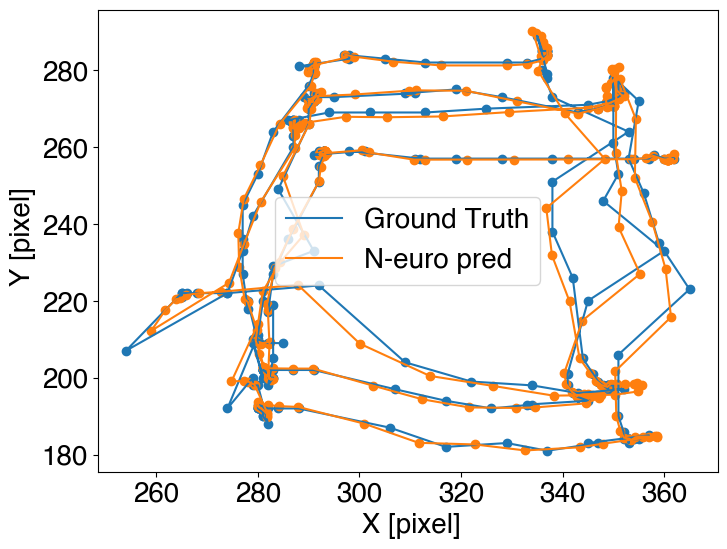

In [18]:
plt.rcParams.update({'font.size': 20, 'font.family': 'Helvetica'})
fig, ax = plt.subplots(figsize=(8, 6))

data_plot = test_data
ax2 = plt.subplot(111)
plt.plot(data_plot['x'][11:-1], data_plot['y'][11:-1], label = 'Ground Truth')
plt.scatter(data_plot['x'][11:-1], data_plot['y'][11:-1])

plt.plot(x_nn_predicted[11:-1,1], y_nn_predicted[11:-1,1] ,label = 'N-euro pred')
plt.scatter(x_nn_predicted[11:-1,1], y_nn_predicted[11:-1,1] )

ax2.set_xlabel(' X [pixel]', fontsize=20)
ax2.set_ylabel(' Y [pixel]', fontsize=20)
plt.legend()

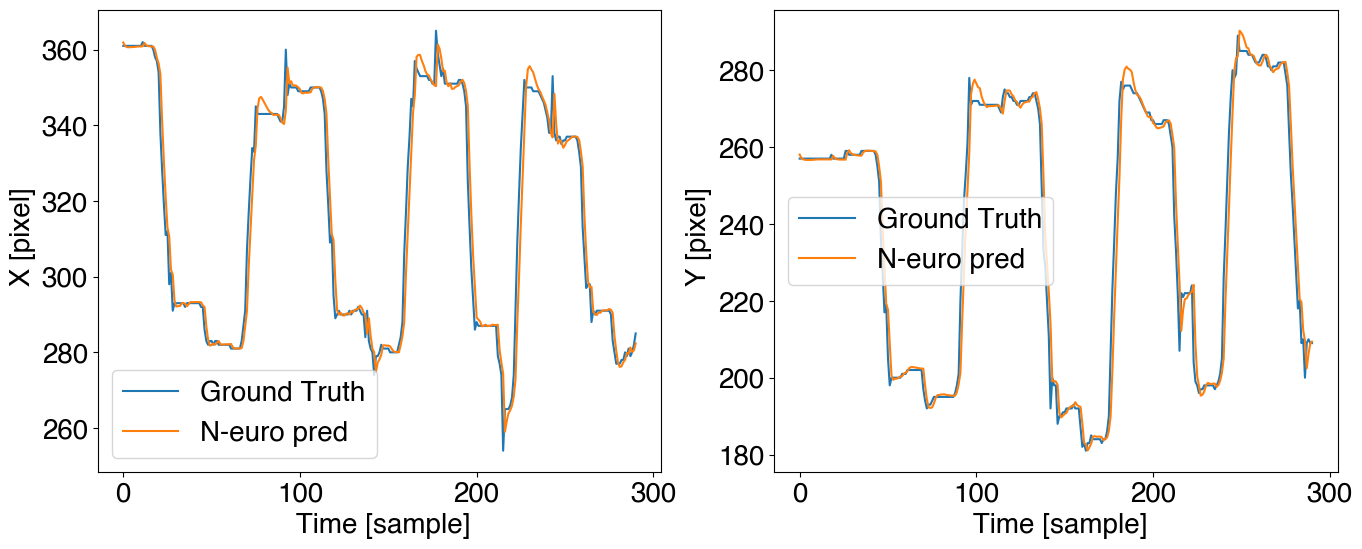

In [19]:
plt.rcParams.update({'font.size': 20, 'font.family': 'Helvetica'})
fig, ax = plt.subplots(figsize=(16, 6))

data_plot = test_data
ax2 = plt.subplot(122)
plt.plot(np.arange(len(data_plot['y'][11:-1])), data_plot['y'][11:-1], label = 'Ground Truth')
plt.plot(np.arange(len(data_plot['y'][11:-1])), y_nn_predicted[11:-1,1] ,label = 'N-euro pred')


ax2.set_ylabel(' Y [pixel]', fontsize=20)
ax2.set_xlabel(' Time [sample]', fontsize=20)
plt.legend()

ax2 = plt.subplot(121)
plt.plot(np.arange(len(data_plot['x'][11:-1])), data_plot['x'][11:-1], label = 'Ground Truth')
plt.plot(np.arange(len(data_plot['x'][11:-1])), x_nn_predicted[11:-1,1] ,label = 'N-euro pred')

ax2.set_ylabel(' X [pixel]', fontsize=20)
ax2.set_xlabel(' Time [sample]', fontsize=20)
plt.legend()

# compare the 3 predictor against ground truth

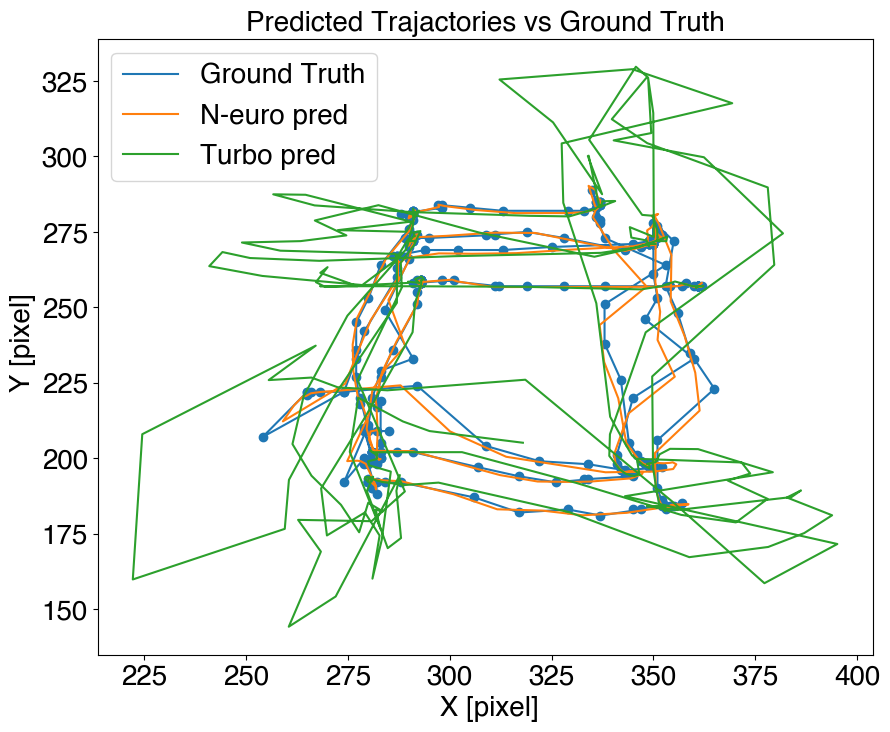

In [21]:
plt.rcParams.update({'font.size': 20, 'font.family': 'Helvetica'})
fig, ax = plt.subplots(figsize=(10, 8))

data_plot = test_data
ax2 = plt.subplot(111)
plt.plot(data_plot['x'][11:-1], data_plot['y'][11:-1], label = 'Ground Truth')
plt.scatter(data_plot['x'][11:-1], data_plot['y'][11:-1])

# plt.plot(x_predicted[11:-1,1], y_predicted[11:-1,1] ,label = 'DEF pred')
plt.plot(x_nn_predicted[11:-1,1], y_nn_predicted[11:-1,1] ,label = 'N-euro pred')
plt.plot(turbo_pred['predX'][11:], turbo_pred['predY'][11:], label = 'Turbo pred')



ax2.set_xlabel(' X [pixel]', fontsize=20)
ax2.set_ylabel(' Y [pixel]', fontsize=20)
ax2.set_title('Predicted Trajactories vs Ground Truth', fontsize=20)

plt.legend()

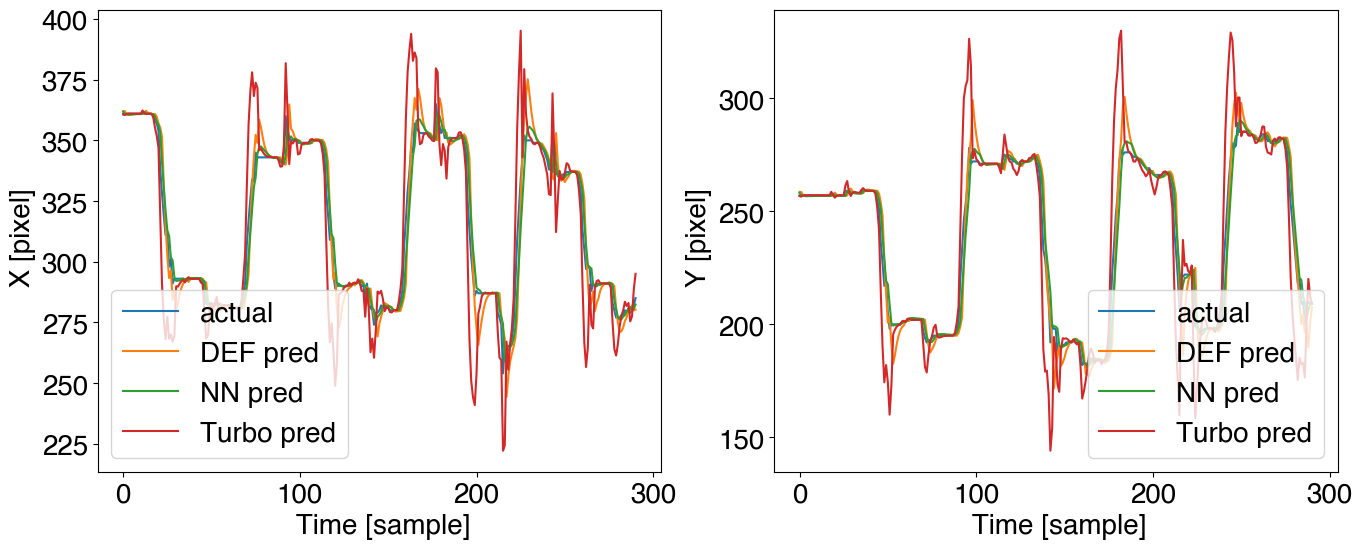

In [74]:
plt.rcParams.update({'font.size': 20, 'font.family': 'Helvetica'})
fig, ax = plt.subplots(figsize=(16, 6))

data_plot = test_data
ax2 = plt.subplot(121)
plt.plot(np.arange(len(data_plot['x'][11:-1])), data_plot['x'][11:-1], label = 'actual')
plt.plot(np.arange(len(data_plot['x'][11:-1])), x_predicted[11:-1,1] ,label = 'DEF pred')
plt.plot(np.arange(len(data_plot['x'][11:-1])), x_nn_predicted[11:-1,1] ,label = 'NN pred')
plt.plot(np.arange(len(data_plot['x'][11:-1])), turbo_pred['predX'][11:-1] ,label = 'Turbo pred')


ax2.set_ylabel(' X [pixel]', fontsize=20)
ax2.set_xlabel(' Time [sample]', fontsize=20)

plt.legend()

ax2 = plt.subplot(122)
plt.plot(np.arange(len(data_plot['y'][11:-1])), data_plot['y'][11:-1], label = 'actual')
plt.plot(np.arange(len(data_plot['y'][11:-1])), y_predicted[11:-1,1] ,label = 'DEF pred')
plt.plot(np.arange(len(data_plot['y'][11:-1])), y_nn_predicted[11:-1,1] ,label = 'NN pred')
plt.plot(np.arange(len(data_plot['x'][11:-1])), turbo_pred['predY'][11:-1] ,label = 'Turbo pred')

ax2.set_ylabel(' Y [pixel]', fontsize=20)
ax2.set_xlabel(' Time [sample]', fontsize=20)
plt.legend()

In [76]:
print("The double exponential prediction error is: ", error_def)
print("The TurboTouch prediction error is: ", error_tur)
print("The N-euro prediction error is: ", error_nn)

The double exponential prediction error is:  10.160310970532974
The TurboTouch prediction error is:  17.706732876712326
The N-euro prediction error is:  8.362761615073843
